In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplolib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log variance
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [32]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(input_dim=784, hidden_dim=400, latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)



for epoch in range(10):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')


Epoch 0, Loss: 165.3868912923177
Epoch 1, Loss: 121.84322708333333
Epoch 2, Loss: 114.59458510742188
Epoch 3, Loss: 111.60850307617187
Epoch 4, Loss: 109.90549752604167
Epoch 5, Loss: 108.68696298828125
Epoch 6, Loss: 107.87883416341145
Epoch 7, Loss: 107.14194397786459
Epoch 8, Loss: 106.69047286783854
Epoch 9, Loss: 106.2750839029948


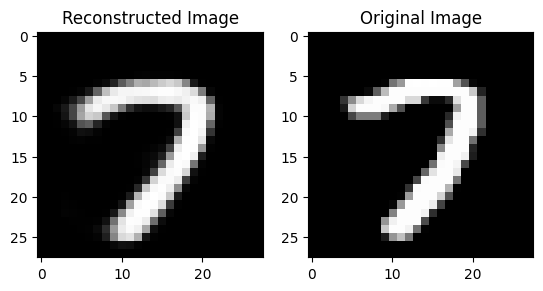

In [42]:

model.eval()
with torch.no_grad():
    data, labels = next(iter(train_loader))
    data = data.to(device)
    # mu, logvar = model.encode(data.view(-1, 784))
    # z = model.reparameterize(mu, logvar)
    recon_batch, mu, logvar = model(data)
    # z = z.cpu().numpy()
    # labels = labels.numpy()

# plt.figure(figsize=(8, 6))
# plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='viridis')
# plt.colorbar()
# plt.xlabel('Latent Dimension 1')
# plt.ylabel('Latent Dimension 2')
# plt.title('Latent Space Visualization')
# plt.show()
plt.subplot(1, 2, 1)
plt.imshow(recon_batch[0].view(28, 28).cpu().numpy(), cmap='gray')
plt.title('Reconstructed Image')
plt.subplot(1, 2, 2)
plt.imshow(data[0].view(28, 28).cpu().numpy(), cmap='gray')
plt.title('Original Image')
plt.show()

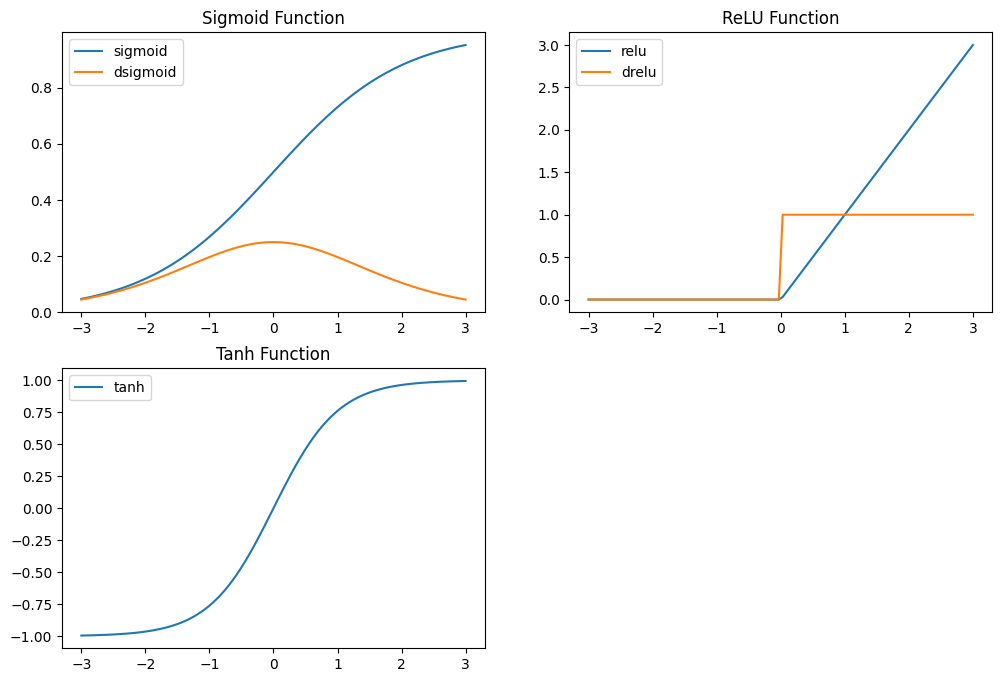

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 3, 100)

def sigmoid(x): 
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend()
plt.title('Sigmoid Function')

plt.subplot(2, 2, 2)
plt.plot(x, relu(x), label='relu')
plt.plot(x, drelu(x), label='drelu')
plt.legend()
plt.title('ReLU Function')

plt.subplot(2, 2, 3)
plt.plot(x, tanh(x), label='tanh')
plt.legend()
plt.title('Tanh Function')

plt.show()

